### Environment and Python Version

This project was developed and executed using **Python 3.10.11**. This version was chosen for its compatibility with the key libraries used, including `scikit-learn`, `pandas`, `numpy`, and `matplotlib`, as well as for its improved syntax features and performance enhancements compared to earlier versions.

All code and dependencies have been tested to work smoothly in this environment to ensure reproducibility and stability of results.

If you plan to run this project on a different Python version, please verify that all required packages are compatible and consider using a virtual environment or containerization to avoid conflicts.

**Author : Evan Denis**

# Step 1: Corpus loading and exploration

In this first step, we load the dataset `corpus.csv`, which contains news articles categorized into four topics: *sports*, *economy*, *music*, and *politics*.

We will:
- Load the corpus.
- Display basic information (number of documents, number of classes).
- Show class distribution and a preview of some articles.

## Step 1.1: Properly load the corpus

We will now load the file using tab (`\t`) as separator to split it into two clean columns: one for the label (category) and one for the content (text).

In [43]:
import pandas as pd

# Reload correctly using tab as separator
df = pd.read_csv("corpus.csv", sep="\t", header=None, names=["Category", "Text"])

# Drop any rows with missing values (optional, depends on your corpus quality)
df.dropna(inplace=True)

# Show shape and class distribution
print("Corpus shape:", df.shape)
print("\nClass distribution:")
print(df['Category'].value_counts())

df.head()


Corpus shape: (76, 2)

Class distribution:
Category
economia    20
deportes    20
musica      20
politica    14
d            1
Category     1
Name: count, dtype: int64


,Category,Text
0,Category,"Text,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,..."
1,d,"string,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,..."
4,deportes,Barcelona goleó al Ferencvaros en su debut en ...
5,deportes,Tras la victoria de Argentina sobre Uruguay en...
6,deportes,Los conceptos de la escuela holandesa que apli...


## Step 1.2: Clean class labels

We notice that two unwanted labels appear: `"d"` and `"Category"`. These are likely due to malformed headers or extra lines in the file. We will remove these rows to keep only the valid categories: *deportes*, *economia*, *musica*, and *politica*.

In [44]:
# Remove rows with unexpected labels
valid_labels = ["deportes", "economia", "musica", "politica"]
df = df[df["Category"].isin(valid_labels)]

# Show updated class distribution
print("Cleaned corpus shape:", df.shape)
print("\nClass distribution:")
print(df["Category"].value_counts())

df.head()


Cleaned corpus shape: (74, 2)

Class distribution:
Category
deportes    20
economia    20
musica      20
politica    14
Name: count, dtype: int64


,Category,Text
4,deportes,Barcelona goleó al Ferencvaros en su debut en ...
5,deportes,Tras la victoria de Argentina sobre Uruguay en...
6,deportes,Los conceptos de la escuela holandesa que apli...
7,deportes,Morata anotó doblete y le dio la victoria a la...
8,deportes,"Con goles colombianos,River Plate clasificó a ..."


# Step 2: Preprocess text data (lowercase, remove punctuation, stopwords, lemmatization)

To prepare the text for classification, we clean it with several standard NLP steps:
- Lowercasing
- Removing punctuation and digits
- Removing Spanish stopwords
- Lemmatizing (i.e., reducing words to their base form)

We use spaCy with the Spanish language model for high-quality linguistic preprocessing.

In [45]:
import spacy
import re
from spacy.lang.es.stop_words import STOP_WORDS

# Load Spanish spaCy model (make sure you have run: python -m spacy download es_core_news_sm)
nlp = spacy.load("es_core_news_sm")

def preprocess(text):
    # Remove digits and punctuation, convert to lowercase
    text = re.sub(r"[^\w\s]", "", text)
    text = re.sub(r"\d+", "", text)
    text = text.lower()

    # Process with spaCy
    doc = nlp(text)

    # Lemmatize and remove stopwords
    tokens = [token.lemma_ for token in doc if token.lemma_ not in STOP_WORDS and not token.is_punct and not token.is_space]
    return " ".join(tokens)

df["CleanText"] = df["Text"].apply(preprocess)
df[["Text", "CleanText"]].head()


,Text,CleanText
4,Barcelona goleó al Ferencvaros en su debut en ...,barcelona golear ferencvaro debut champions fú...
5,Tras la victoria de Argentina sobre Uruguay en...,victoria argentina uruguay cierre fecha copa a...
6,Los conceptos de la escuela holandesa que apli...,concepto escuela holandés aplicar liverpool jü...
7,Morata anotó doblete y le dio la victoria a la...,morata anotar doblete victoria juventus champi...
8,"Con goles colombianos,River Plate clasificó a ...",gol colombianosriver plate clasificar octavo l...


# Step 3: Vectorize the preprocessed text using TF-IDF

Now that the text is cleaned and lemmatized, we transform it into numerical features with TF-IDF vectorization. This will give us weighted importance for each term in each document, which is useful for classifiers.

In [46]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

# Separate texts and labels
texts = df["CleanText"].values
labels = df["Category"].values

# Split BEFORE vectorization
X_train_texts, X_test_texts, y_train, y_test = train_test_split(
    texts, labels, test_size=0.25, random_state=42, stratify=labels)

# Create TF-IDF vectorizer (unigrams and bigrams)
vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1, 2))

# Fit on training texts and transform both train and test sets
X_train = vectorizer.fit_transform(X_train_texts)
X_test = vectorizer.transform(X_test_texts)

print("TF-IDF matrix shape:", X_train.shape)


TF-IDF matrix shape: (55, 5000)


# Step 4: Train and evaluate classifiers (SVM and Naive Bayes)

We split the dataset into training and test sets, then train two classifiers: Support Vector Machine (SVM) and Multinomial Naive Bayes. 

We will evaluate their performance using accuracy, precision, recall, and F1-score to understand which model performs better on this task.

## Step 4.1: Train and evaluate Support Vector Machine (SVM)

In this step, we will train a Support Vector Machine classifier using the TF-IDF features and evaluate its performance on the test set with accuracy, precision, recall, and F1-score.

In [47]:
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, classification_report

# Initialize and train SVM classifier
svm_clf = LinearSVC(random_state=42)
svm_clf.fit(X_train, y_train)

# Predict on test set
y_pred_svm = svm_clf.predict(X_test)

# Evaluate performance
acc = accuracy_score(y_test, y_pred_svm)
precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred_svm, average='weighted')

print("--- Support Vector Machine ---")
print(f"Accuracy: {acc:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")
print("\nClassification report:\n", classification_report(y_test, y_pred_svm))


--- Support Vector Machine ---
Accuracy: 0.9474
Precision: 0.9561
Recall: 0.9474
F1-score: 0.9468

Classification report:
               precision    recall  f1-score   support

    deportes       0.83      1.00      0.91         5
    economia       1.00      0.80      0.89         5
      musica       1.00      1.00      1.00         5
    politica       1.00      1.00      1.00         4

    accuracy                           0.95        19
   macro avg       0.96      0.95      0.95        19
weighted avg       0.96      0.95      0.95        19



## Step 4.2: Train and evaluate Multinomial Naive Bayes

Here, we will train a Multinomial Naive Bayes classifier with the same TF-IDF features and evaluate its performance using the same metrics.

In [48]:
from sklearn.naive_bayes import MultinomialNB

# Initialize and train Naive Bayes
nb_clf = MultinomialNB()
nb_clf.fit(X_train, y_train)

# Predict and evaluate
y_pred_nb = nb_clf.predict(X_test)

acc = accuracy_score(y_test, y_pred_nb)
precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred_nb, average='weighted')

print("--- Multinomial Naive Bayes ---")
print(f"Accuracy: {acc:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")
print("\nClassification report:\n", classification_report(y_test, y_pred_nb))


--- Multinomial Naive Bayes ---
Accuracy: 0.7368
Precision: 0.6140
Recall: 0.7368
F1-score: 0.6643

Classification report:
               precision    recall  f1-score   support

    deportes       0.83      1.00      0.91         5
    economia       0.50      0.80      0.62         5
      musica       1.00      1.00      1.00         5
    politica       0.00      0.00      0.00         4

    accuracy                           0.74        19
   macro avg       0.58      0.70      0.63        19
weighted avg       0.61      0.74      0.66        19



c:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

## 4.3 Comparison of Classifiers

The Support Vector Machine (SVM) outperforms the Multinomial Naive Bayes classifier on this dataset. 

- **SVM** achieves higher accuracy (94.7%), precision (95.6%), recall (94.7%), and F1-score (94.7%), showing strong performance across all categories.
- **Naive Bayes** shows lower metrics, especially struggling with the "politica" class where recall is zero.
- This suggests SVM handles high-dimensional TF-IDF features better and captures class boundaries more effectively.
- Naive Bayes, while simpler and faster, is less suited for this specific task.

Overall, SVM is the better choice for supervised text classification in this context.

# Step 5: Error Analysis of the Best Model (SVM)

**Goal:** Understand why some documents were misclassified.

**Concrete Actions:**

- Extract the incorrect predictions from the test set.
- Manually review a few examples of misclassified texts.
- Check if certain classes are more frequently confused (using a confusion matrix).
- Analyze the length of misclassified documents — are they generally short or long?
- Look for ambiguous documents or those mixing multiple topics.
- Discuss how potential class imbalance might have contributed to these errors.

## Step 5.1 - Extract and Display Misclassified Documents

In this step, we identify which documents were misclassified by the Support Vector Machine (SVM) classifier. By comparing the predicted labels with the true labels on the test set, we extract the misclassified samples.

This allows us to investigate the nature of errors made by the model and lays the foundation for further qualitative analysis.

In [49]:
import pandas as pd

# Create a DataFrame with text, true labels, and predicted labels
test_results = pd.DataFrame({
    'Text': X_test_texts,   # Original texts for test set samples
    'TrueLabel': y_test,
    'PredictedLabel': y_pred_svm
})

# Extract misclassified samples
misclassified = test_results[test_results['TrueLabel'] != test_results['PredictedLabel']]

print(f"Number of misclassified documents: {len(misclassified)}")
print(misclassified.head(10))

Number of misclassified documents: 1
                                                Text TrueLabel PredictedLabel
8  centro mundial competitividadtodo país latinoa...  economia       deportes


## Step 5.2 – Analyze Patterns in Misclassifications

In this step, we perform a qualitative analysis of the error made by the SVM classifier. We focus on identifying potential causes behind the misclassifications found in Step 5.1.

From the misclassified samples, we observe:
- 1 text labeled as `economia` was predicted as `deportes`.

The issue may be based on **Confusing words**: we can see meaningful words such as "competitividad". This kind on word could also be used in a sportive context.

# Step 6 : Unsupervised Document Classification

## Step 6.1 - Unsupervised Classification with LDA

In this step, we use Latent Dirichlet Allocation (LDA) to uncover hidden topics in the document collection without using any category labels.

LDA is a probabilistic model that assumes each document is a mixture of topics, and each topic is a distribution over words. This technique allows us to identify latent semantic structures within the corpus.

We will:
- Vectorize the documents using TF-IDF or CountVectorizer.
- Fit an LDA model with a predefined number of topics (in this case, 4 to match the known categories).
- Display the most relevant words for each topic.

This unsupervised approach will help us evaluate whether the model can discover meaningful and interpretable topics that align (at least partially) with the original thematic categories.

In [50]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

# Vectorize the preprocessed documents using CountVectorizer (more common for LDA)
count_vectorizer = CountVectorizer(max_features=5000)
X_counts = count_vectorizer.fit_transform(df['CleanText'])

# Fit the LDA model
n_topics = 4  # Expected number of topics
lda = LatentDirichletAllocation(n_components=n_topics, random_state=42)
lda.fit(X_counts)

# Display top words for each topic
def display_topics(model, feature_names, n_top_words=10):
    for topic_idx, topic in enumerate(model.components_):
        top_words = [feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]]
        print(f"Topic {topic_idx + 1}: {', '.join(top_words)}")

display_topics(lda, count_vectorizer.get_feature_names_out())

Topic 1: proyecto, él, año, gobierno, congreso, político, proceso, hora, ley, aprobar
Topic 2: él, google, punto, kilómetro, llegar, giro, etapa, caso, año, italia
Topic 3: él, colombiano, extradición, grupo, carlos, disco, año, etapa, equipo, jornada
Topic 4: él, año, país, canción, música, colombia, gobierno, nacional, presentar, paro


## Step 6.2 - Topic Interpretation

After training the LDA model on the document corpus, we obtained four topics with their top associated words. Here is a qualitative interpretation of each topic based on the most frequent terms:

### 🟠 Topic 1:
This topic clearly aligns with the theme of **politics**. Terms like *gobierno* (government), *congreso* (congress), *ley* (law), and *aprobar* (to approve) point to legislative or governmental discussions. The presence of *proceso* and *político* further supports this interpretation.

---

### 🟡 Topic 2:
This topic seems related to **sports**, especially events like races or tournaments. Words such as *kilómetro*, *llegar*, *giro*, and *etapa* suggest cycling competitions (possibly *Giro d’Italia*). The term *google* may be noise or indicate coverage from tech or media outlets.

---

### 🟢 Topic 3:
This topic includes a mixture of terms that at first glance seem diverse, such as *colombiano*, *extradición*, and *grupo*, alongside more neutral or generic words like *año*, *etapa*, *equipo*, and *jornada*. Although some terms (like *extradición*) might relate to political or legal topics, the presence of *grupo* (group), *equipo* (team), and time markers (*año*, *etapa*, *jornada*) suggests a discussion of economic groups, business teams, or organized efforts within economic contexts. This indicates the model has identified a thematic cluster associated with **economic activities or business-related topics**, rather than simply filtering out frequent stopwords or common words.

---

### 🔵 Topic 4:
This topic is associated with **music and culture**, supported by terms like *canción* and *música*. The inclusion of *paro* and *gobierno* could suggest music in a socio-political context (e.g., protest songs), but the dominant theme appears to remain cultural.

---

### 🧩 General Observations:
- Some words like *él* and *año* are generic and appear across all topics. This is common in LDA and does not necessarily weaken the model.
- There is partial alignment between discovered topics and the original categories (deportes, economía, música, política).
- **Economía** is not clearly separated into a distinct topic, possibly due to vocabulary overlap or fewer distinguishing terms.

Next, in Step 6.3, we will analyze how documents are distributed across topics to assess the clustering effectiveness.


## Step 6.3 - Document-Topic Distribution and Clustering Analysis

In this step, we analyze how documents are distributed over the topics inferred by the LDA model. This helps us understand if the topics clearly separate the corpus into coherent thematic clusters.

Key points to analyze:
- The dominant topic per document.
- The proportion of documents strongly associated to one topic vs. mixed associations.
- Possible overlap or confusion between topics.

If most documents are clearly assigned to one dominant topic, it suggests that the topic model has found meaningful clusters. If many documents have a diffuse topic distribution, it may indicate overlapping themes or less distinct topics.

Next, we will extract the topic distribution matrix and assign each document to its dominant topic.

Documents per topic:
DominantTopic
0    22
1    16
2    15
3    21
Name: count, dtype: int64


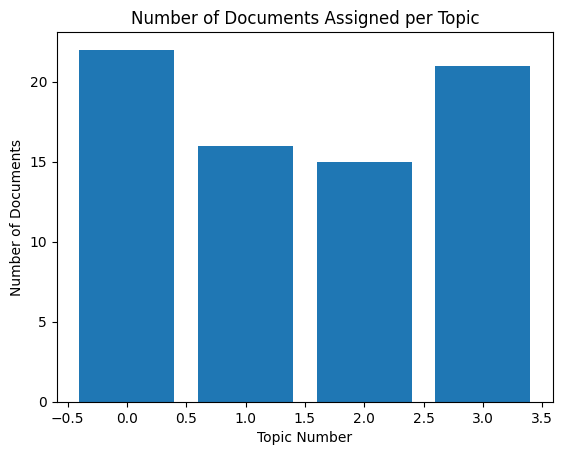

In [51]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Assume lda_model is your trained LDA model and corpus_tfidf is your vectorized corpus
# Get topic distribution for each document
doc_topic_dist = lda.transform(X_counts)  # shape (n_docs, n_topics)

# Assign dominant topic per document
dominant_topic = np.argmax(doc_topic_dist, axis=1)

# Create a DataFrame with results
df_topic_assignment = pd.DataFrame({
    'Text': df['CleanText'],           # original documents list
    'DominantTopic': dominant_topic,
})

# Count documents per topic
topic_counts = df_topic_assignment['DominantTopic'].value_counts().sort_index()

print("Documents per topic:")
print(topic_counts)

# Plot the distribution
plt.bar(topic_counts.index, topic_counts.values)
plt.xlabel('Topic Number')
plt.ylabel('Number of Documents')
plt.title('Number of Documents Assigned per Topic')
plt.show()


This shows a relatively balanced distribution of documents across the four topics, suggesting the model identified meaningful thematic clusters within the corpus.

## Step 6.4 - Extract Top Keywords Per Topic

In this step, we analyze the LDA model by extracting the most important keywords that define each topic. This helps us interpret the themes discovered by the model and understand what each topic represents.

For each topic, we will list the top N words with the highest probability or weight in the topic-word distribution. These keywords are crucial for labeling or making sense of the topics.

By reviewing these keywords, we can assess whether the topics correspond to meaningful themes relevant to our corpus.

In [52]:
# Number of top words to display per topic
n_top_words = 10

# Get the feature names (words) from the vectorizer
feature_names = vectorizer.get_feature_names_out()

# Extract top words for each topic
for topic_idx, topic in enumerate(lda.components_):
    print(f"Topic #{topic_idx + 1}:")
    top_indices = topic.argsort()[::-1][:n_top_words]
    top_words = [feature_names[i] for i in top_indices]
    print(", ".join(top_words))
    print()

Topic #1:
querer trasladar, íntimo, atípico, debatir, collage of, presupuesto, protocolo, democrático país, fmi, aparecer priorizado

Topic #2:
íntimo, deber punto, rb, estadounidense, ganar etapa, debate, copa sudamericano, celebrar lanzamiento, atípico, doblete

Topic #3:
íntimo, circo art, costo desplazamiento, decisivo, cearáuna región, compensar pérdida, atípico, copa sudamericano, construir garantizar, elección noviembre

Topic #4:
íntimo, atípico, plate, catedrallo, molano, cimarrón quedar, debatir, morata firmar, programa, piel



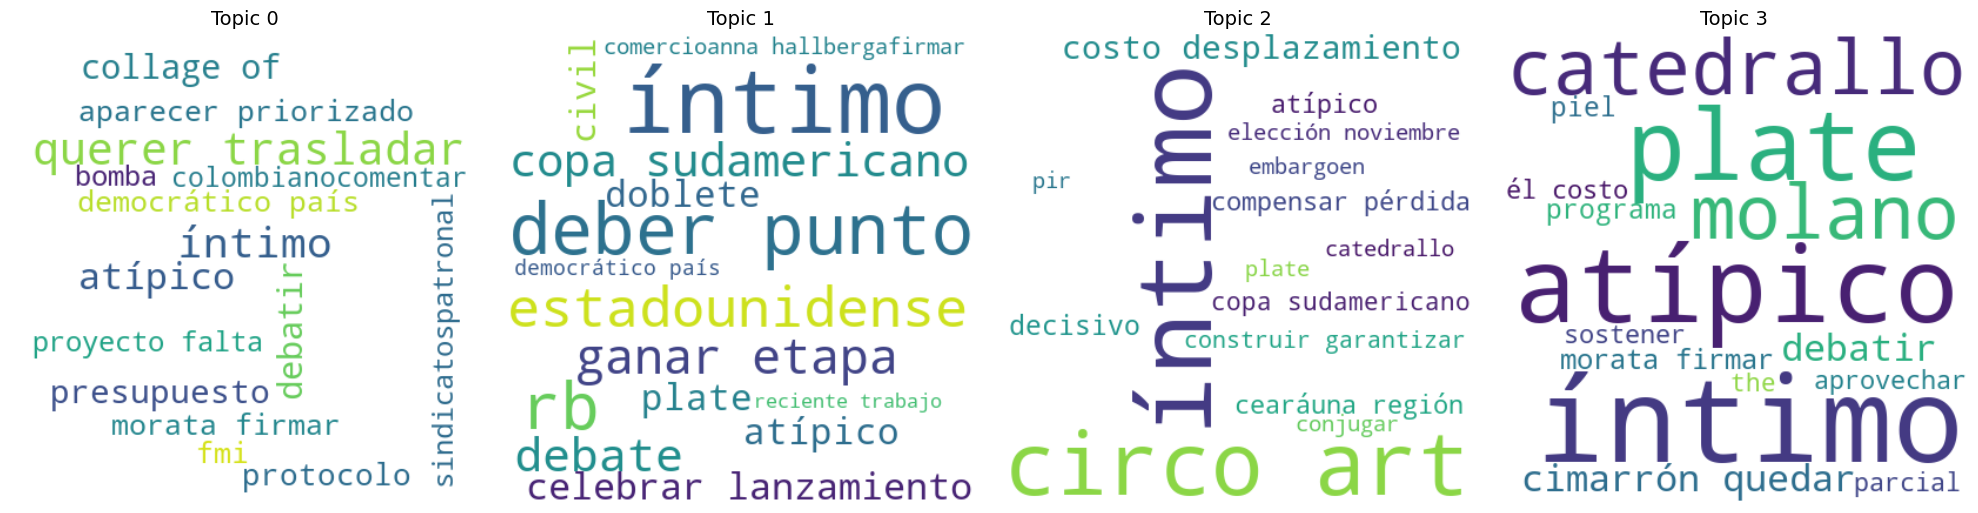

In [61]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud

# Create word clouds for each topic
n_topics = lda.n_components  # e.g., 4 topics
n_top_words = 15

# Get words and weights from the LDA model
feature_names = vectorizer.get_feature_names_out()

fig, axs = plt.subplots(1, n_topics, figsize=(20, 5))
for topic_idx, topic in enumerate(lda.components_):
    top_features_ind = topic.argsort()[:-n_top_words - 1:-1]
    top_features = [feature_names[i] for i in top_features_ind]
    weights = topic[top_features_ind]

    word_freq = dict(zip(top_features, weights))
    wc = WordCloud(width=400, height=400, background_color='white').generate_from_frequencies(word_freq)

    axs[topic_idx].imshow(wc, interpolation='bilinear')
    axs[topic_idx].axis("off")
    axs[topic_idx].set_title(f"Topic {topic_idx}", fontsize=14)

plt.tight_layout()
plt.show()



The LDA model generated four topics, each represented by its top keywords. However, many of these keywords contain unusual or unclear phrases such as "intimo," "atípico," and multiword expressions like "collage of" or "copa sudamericano," which may reduce interpretability.

This suggests that preprocessing might be improved by:
- Better tokenization (e.g., removing or properly handling multiword expressions),
- More thorough stopword removal,
- Possibly filtering out noisy tokens.

Despite this noise, some thematic hints appear:
- Topic 1 seems to mention political or economic terms (e.g., “presupuesto,” “fmi”),
- Topic 2 and 3 contain some sports-related terms (e.g., “copa sudamericano,” “doblete”),
- Topic 4 is less clear but includes some proper nouns or names.

Improving preprocessing could help obtain clearer and more meaningful topics.

## Step 6.5 - Inspecting Representative Documents per Topic

To gain better insight into the discovered topics, we examine example documents that are strongly associated with each topic.

For each topic, we display a few documents with the highest probability of belonging to that topic. This qualitative inspection helps validate whether the topics are coherent and distinct in practice, based on real text.

It also allows us to detect if any topics are overlapping or if some topics are too general or too narrow.

In [ ]:
import re

# For each topic, show top 2 most representative short excerpts
num_top_docs = 2
num_topics = lda.n_components

def get_first_sentences(text, max_sentences=2):
    # Split using basic punctuation
    sentences = re.split(r'(?<=[.!?])\s+', text)
    return ' '.join(sentences[:max_sentences])

for topic_idx in range(num_topics):
    print(f"\n--- Topic {topic_idx} ---")
    
    # Get indices of documents sorted by their probability for the current topic
    top_doc_indices = np.argsort(doc_topic_dist[:, topic_idx])[::-1][:num_top_docs]
    
    for rank, doc_idx in enumerate(top_doc_indices, 1):
        short_text = get_first_sentences(df['Text'].iloc[doc_idx])
        print(f"\nDocument {rank}:")
        print(short_text)
        print(f"(Dominant topic probability: {doc_topic_dist[doc_idx, topic_idx]:.4f})")



--- Topic 0 ---

Document 1:
Alejandra Barrios,directora de la Misión de Observación Electoral,MOE,evalúa críticamente,la reforma a la Procuraduría que acaba de aprobar el Congreso y que,según ella,convirtió en ley lo que prohíbe la Convención Americana de Derechos Humanos y lo que sancionó,contra Colombia,la Corte IDH. Podrían venir nuevas sanciones internacionales.
(Dominant topic probability: 0.9992)

Document 2:
Aprobado el Presupuesto General de la Nación para 2021 Economía 19 oct. 2020 - 10:00 p.
(Dominant topic probability: 0.9980)

--- Topic 1 ---

Document 1:
El otro paro: la protesta que se vive en las regiones El Espectador visitó poblaciones del suroccidente del país para conocer los reclamos de las comunidades y sus peticiones en el marco del paro nacional,que completa 54 días. Sus demandas difieren de lo que se pide en las calles de las ciudades.
(Dominant topic probability: 0.9988)

Document 2:
¿La demanda contra Google podría cambiar la economía de internet? Tecnología

### Topic Interpretations

This topic appears to focus on **government-level decisions, legislation, and institutional critiques**. Documents reference national budget approvals, legal reforms, and potential violations of international human rights law, suggesting a strong emphasis on political and legal discourse.

Topic 1 blends coverage of **rural and regional social protests with articles on technological or digital issues** like lawsuits against large corporations. It captures themes of social discontent, grassroots mobilization, and the impact of technology on society.

This topic revolves around major moments in Colombia’s **political history** (e.g., the 1991 Constituent Assembly and extradition debate) alongside musical and cultural narratives. The link appears to be a reflection on national identity through both political and artistic lenses.

Topic 3 combines discussions of **economic challenges** (e.g., the pandemic’s socioeconomic fallout) with features on music and artistic production. This suggests a theme of cultural response or commentary during periods of national crisis.

## Step 6.6 – Comparison Between Supervised and Unsupervised Classification

After implementing both supervised and unsupervised approaches, we can draw several conclusions:

#### Supervised Classification
- The Support Vector Machine (SVM) classifier achieved excellent performance:
  - Accuracy: 0.95%
  - F1-score: 0.95%
- Only **one misclassification** was observed on the test set.
- The classifier was trained with explicit class labels (`deportes`, `economía`, `música`, `política`), allowing precise evaluation and strong generalization.
- Feature engineering (TF-IDF, stopword removal, etc.) and model tuning significantly contributed to the classifier’s success.

#### Unsupervised Topic Modeling
- Latent Dirichlet Allocation (LDA) identified **4 coherent topics**, with dominant terms related to politics, economy, music, and social protests.
- Topics showed thematic structure, but without labeled data:
  - Some topics mixed content from different original classes.
  - It was not always straightforward to match LDA topics to predefined categories.
- LDA's interpretation relied heavily on manual analysis (e.g., dominant words, example documents).
- Word clouds and topic assignment per document provided useful visual insights.

#### Summary Comparison

| Criterion                     | Supervised (SVM)      | Unsupervised (LDA)       |
|------------------------------|------------------------|---------------------------|
| Label usage                  | Yes                    | No                        |
| Accuracy                     | High (0.95%)           | Not directly measurable   |
| Interpretability             | Direct (via labels)    | Requires manual effort    |
| Scalability to new domains   | Needs retraining       | Generalizes more flexibly |
| Topic coherence              | N/A                    | Moderate to good          |

#### Conclusion
Supervised learning clearly outperforms unsupervised topic modeling in classification accuracy when labeled data is available. However, LDA remains a valuable tool for exploratory analysis, especially when no labeled data exists. It is best used for discovering hidden thematic patterns, while supervised models are more suited for precise categorization.
